In [1]:
import tensorflow as tf
import malaya_speech
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import malaya_speech.augmentation.waveform as augmentation

In [2]:
tf.compat.v1.enable_eager_execution()

In [3]:
from glob import glob

files = glob('../youtube/clean-wav/*.wav')
len(files)

15385

In [4]:
noises = glob('../noise-44k/noise/*.wav')
len(noises)

182

In [5]:
y, sr = malaya_speech.load(files[0], sr = 44100)
y = y[:sr * 10]
y = y.astype(np.float32)
len(y) / sr / 60, sr

(0.16666666666666666, 44100)

In [6]:
y1, sr = malaya_speech.load(files[-1], sr = 44100)
y1 = y1[:sr * 10]
y1 = y1.astype(np.float32)
len(y1) / sr / 60, sr

(0.16666666666666666, 44100)

In [7]:
noise, sr = malaya_speech.load(noises[0], sr = 44100)
noise1, sr = malaya_speech.load(noises[-1], sr = 44100)

In [8]:
ipd.Audio(noise, rate = sr)

In [9]:
ipd.Audio(noise1, rate = sr)

In [10]:
def add_uniform_noise(sample, power = 0.01, return_noise = False):
    y_noise = sample.copy()
    noise_amp = power * np.random.uniform() * np.amax(y_noise)
    noise = noise_amp * np.random.normal(size = y_noise.shape[0])
    y_noise = y_noise + noise
    noise = noise / np.max(np.abs(y_noise))
    y_noise = y_noise / np.max(np.abs(y_noise))
    if return_noise:
        return y_noise, noise
    else:
        return y_noise

def add_noise(
    sample, noise, random_sample = True, factor = 0.1, return_noise = False
):
    y_noise = sample.copy()
    if len(y_noise) > len(noise):
        noise = np.tile(noise, int(np.ceil(len(y_noise) / len(noise))))
    else:
        if random_sample:
            noise = noise[np.random.randint(0, len(noise) - len(y_noise) + 1) :]
    noise = noise[: len(y_noise)] * factor
    y_noise = y_noise + noise
    noise = noise / np.max(np.abs(noise))
    y_noise = y_noise / np.max(np.abs(y_noise))
    if return_noise:
        return y_noise, noise
    else:
        return y_noise

In [11]:
combined, noise_ = add_noise(y, noise, factor = 0.5, return_noise = True)
combined = combined.astype('float32')
noise_ = noise_.astype('float32')

In [12]:
ipd.Audio(combined, rate = sr)

In [13]:
ipd.Audio(noise_, rate = sr)

/home/husein/.local/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/husein/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


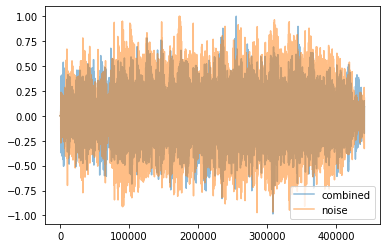

In [14]:
plt.plot(combined, alpha = 0.5, label = 'combined')
plt.plot(noise_, alpha = 0.5, label = 'noise')
plt.legend()

In [16]:
def pad_and_partition(tensor, segment_len):
    tensor_size = tf.math.floormod(tf.shape(tensor)[0], segment_len)
    pad_size = tf.math.floormod(segment_len - tensor_size, segment_len)
    padded = tf.pad(
        tensor,
        [[0, pad_size]] + [[0, 0]] * (len(tensor.shape)-1))
    split = (tf.shape(padded)[0] + segment_len - 1) // segment_len
    return tf.reshape(
        padded,
        tf.concat(
            [[split, segment_len], tf.shape(padded)[1:]],
            axis=0))

In [17]:
from tensorflow.signal import stft, inverse_stft, hann_window

def get_stft(y, return_magnitude = True, frame_length = 4096, frame_step = 1024, T = 512, F = 1024):
    
    waveform = tf.concat([
        tf.zeros((frame_length, 1)),
        tf.expand_dims(y, -1)
    ], 0
    )
    stft_feature = tf.transpose(
        stft(
            tf.transpose(waveform),
            frame_length,
            frame_step,
            window_fn=lambda frame_length, dtype: (
                hann_window(frame_length, periodic=True, dtype=dtype)),
            pad_end=True),
        perm=[1, 2, 0])
    if return_magnitude:
        D = tf.abs(pad_and_partition(stft_feature, T))[:, :, :F, :]
        return stft_feature, D
    else:
        return stft_feature
    
def istft(stft_t, y, time_crop=None, factor = 2 / 3,
                frame_length = 4096, frame_step = 1024, T = 512, F = 1024):
    
    inversed = inverse_stft(
        tf.transpose(stft_t, perm=[2, 0, 1]),
        frame_length,
        frame_step,
        window_fn=lambda frame_length, dtype: (
            hann_window(frame_length, periodic=True, dtype=dtype))
    ) * factor
    reshaped = tf.transpose(inversed)
    if time_crop is None:
        time_crop = tf.shape(y)[0]
    return reshaped[frame_length:frame_length+time_crop, :]

In [26]:
stft_combined, D_combined = get_stft(combined)
stft_noise, D_noise = get_stft(noise.astype('float32'))
stft_y, D_y = get_stft(y.astype('float32'))

In [19]:
tf.reduce_min(D_combined), tf.reduce_max(D_combined)

(<tf.Tensor: id=359, shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: id=361, shape=(), dtype=float32, numpy=268.85718>)

In [20]:
tf.reduce_min(D_noise), tf.reduce_max(D_noise)

(<tf.Tensor: id=363, shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: id=365, shape=(), dtype=float32, numpy=496.5087>)

In [21]:
def pad_and_reshape(instr_spec, frame_length, frame_step = 1024, T = 512, F = 1024):
    """
    :param instr_spec:
    :param frame_length:
    :param F:
    :returns:
    """
    spec_shape = tf.shape(instr_spec)
    extension_row = tf.zeros((spec_shape[0], spec_shape[1], 1, spec_shape[-1]))
    n_extra_row = (frame_length) // 2 + 1 - F
    extension = tf.tile(extension_row, [1, 1, n_extra_row, 1])
    extended_spec = tf.concat([instr_spec, extension], axis=2)
    old_shape = tf.shape(extended_spec)
    new_shape = tf.concat([
        [old_shape[0] * old_shape[1]],
        old_shape[2:]],
        axis=0)
    processed_instr_spec = tf.reshape(extended_spec, new_shape)
    return processed_instr_spec

def _extend_mask(mask, extension = 'zeros', frame_length = 4096, frame_step = 1024, T = 512, F = 1024):
    if extension == "average":
        extension_row = tf.reduce_mean(mask, axis=2, keepdims=True)
    elif extension == "zeros":
        mask_shape = tf.shape(mask)
        extension_row = tf.zeros((
            mask_shape[0],
            mask_shape[1],
            1,
            mask_shape[-1]))
    else:
        raise ValueError(f'Invalid mask_extension parameter {extension}')
    n_extra_row = frame_length // 2 + 1 - F
    extension = tf.tile(extension_row, [1, 1, n_extra_row, 1])
    return tf.concat([mask, extension], axis=2)

In [27]:
separation_exponent = 2
EPSILON = 1e-10

output_sum = tf.reduce_sum(
        [D_y ** separation_exponent, D_noise ** separation_exponent],
        axis=0) + EPSILON

r = {}
for no, D in enumerate([D_y, D_noise]):

    instrument_mask = (D ** separation_exponent + (EPSILON / 2)) / output_sum
    instrument_mask = _extend_mask(instrument_mask)
    old_shape = tf.shape(instrument_mask)
    new_shape = tf.concat(
        [[old_shape[0] * old_shape[1]], old_shape[2:]],
        axis=0)
    instrument_mask = tf.reshape(instrument_mask, new_shape)

    instrument_mask = instrument_mask[:tf.shape(stft_combined)[0], ...]
    masked_stft = tf.cast(instrument_mask, dtype=tf.complex64) * stft_combined
    r[no] = istft(masked_stft, y1)[:,0].numpy()

In [29]:
ipd.Audio(r[0], rate = sr)

In [28]:
ipd.Audio(r[1], rate = sr)